Начать с использования регрессии случайного леса в качестве базовой модели. Я выбрал случайный лес, поскольку он относительно прост для понимания, обобщает хорошо и не требует масштабирования данных или большого количества предварительной обработки

RMSE модели:  3.1160925650879676
RMSE константной модели:  181.6781183339868
Fitting 5 folds for each of 27 candidates, totalling 135 fits
RMSE лучшей модели:  3.056349552409119
registered: 1.538 +/- 0.032
casual: 0.108 +/- 0.003
hour: 0.000 +/- 0.000
atemp: 0.000 +/- 0.000
temp: 0.000 +/- 0.000
month: 0.000 +/- 0.000
weather: 0.000 +/- 0.000
humidity: 0.000 +/- 0.000
year: 0.000 +/- 0.000
workingday: 0.000 +/- 0.000
holiday: 0.000 +/- 0.000
season: -0.000 +/- 0.000
day: -0.000 +/- 0.000
windspeed: -0.000 +/- 0.000


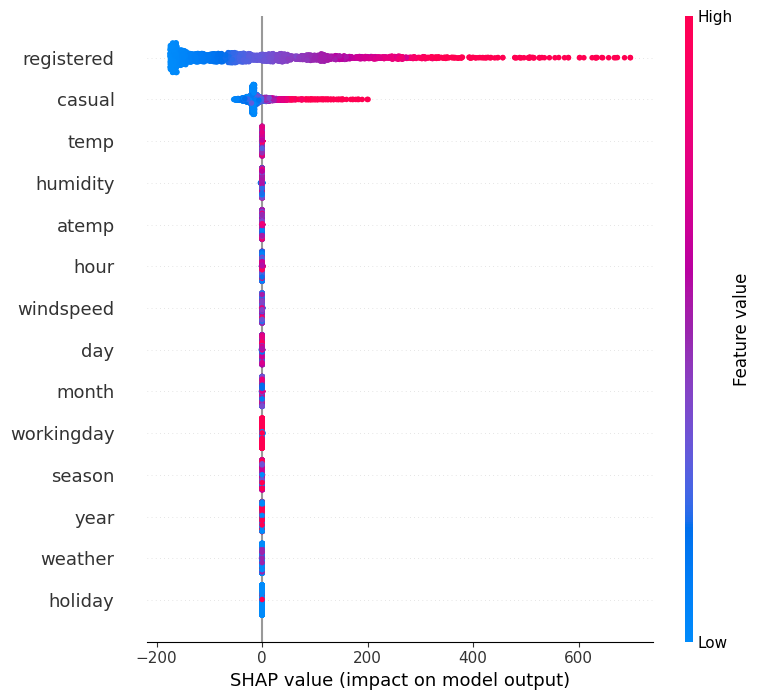

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
from sklearn.inspection import permutation_importance
import shap

# Загрузим данные
df = pd.read_csv('Yulu.csv')

# Преобразуем 'datetime' в datetime формат и извлечем отдельные признаки
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour

# Теперь можем удалить 'datetime'
df = df.drop(columns=['datetime'])

# Извлечем векторы меток и признаков.
X = df.drop('count', axis=1)
y = df['count']

# Разделим данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучаем базовую модель
baseline_model = RandomForestRegressor(random_state=42)
baseline_model.fit(X_train, y_train)

# Предсказания модели на тестовом наборе
y_pred = baseline_model.predict(X_test)

# Вычисляем RMSE
rmse_model = sqrt(mean_squared_error(y_test, y_pred))
print("RMSE модели: ", rmse_model)

# Предсказания в виде среднего значения 'count'
y_mean = np.full(len(y_test), y_train.mean())

# Вычисляем RMSE для среднего значения
rmse_mean = sqrt(mean_squared_error(y_test, y_mean))
print("RMSE константной модели: ", rmse_mean)

# Подбор гиперпараметров с использованием GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [10, 20, 30],
    'random_state': [42]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Предсказания на тестовом наборе с лучшей моделью
y_pred_best = best_model.predict(X_test)
rmse_best_model = sqrt(mean_squared_error(y_test, y_pred_best))
print("RMSE лучшей модели: ", rmse_best_model)

# Важность признаков с использованием permutation importances
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
for i in perm_importance.importances_mean.argsort()[::-1]:
    print(f"{X.columns[i]}: {perm_importance.importances_mean[i]:.3f} +/- {perm_importance.importances_std[i]:.3f}")

# Важность признаков с использованием SHAP
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

На изображении представлен график SHAP summary plot, показывающий влияние различных признаков на предсказания модели. Давайте интерпретируем результаты:

# Интерпретация SHAP summary plot
1. `registered` и `casual`:

  - Эти два признака имеют наибольшее влияние на предсказания модели.
  - Высокие значения этих признаков увеличивают предсказанное количество велосипедов.
  - Сильное влияние этих признаков может быть связано с тем, что они непосредственно указывают на количество зарегистрированных и не зарегистрированных пользователей, что естественно коррелирует с общей численностью велосипедов.
2. `temp`, `humidity`, `atemp`, и `windspeed`:

  - Признаки, связанные с погодой, также оказывают значительное влияние на модель.
  - Например, высокая температура (temp) и ощущаемая температура (atemp) увеличивают количество велосипедов, в то время как высокая влажность (humidity) и скорость ветра (windspeed) могут снижать его.
3. `hour`, `day`, и `month`:

  - Временные признаки, такие как час, день и месяц, также играют важную роль.
  - Например, спрос на велосипеды может быть выше в определенные часы дня (например, утренние и вечерние часы пик) и в определенные дни недели (выходные или будние дни).
4. `workingday`, `season`, `year`, `weather`, и `holiday`:

  - Эти признаки оказывают менее значительное, но все же важное влияние.
  - Рабочие и нерабочие дни (workingday), сезоны (season), годы (year), погодные условия (weather) и праздники (holiday) могут влиять на спрос на велосипеды.

# Выводы

1. Значимость `registered` и `casual`:

  - Эти признаки логично оказывают значительное влияние, так как они напрямую связаны с количеством пользователей. Рекомендации по улучшению модели могут включать проверку достоверности и полноты данных по этим признакам.
2. Погодные признаки:

  - Влияние погодных условий на спрос является ожидаемым, так как погода влияет на комфорт и безопасность езды на велосипеде. Убедитесь, что данные по погодным условиям точны и актуальны.
3. Временные признаки:

  - Признаки, связанные с временем, такие как час и день, играют ключевую роль. Это может указывать на необходимость использования сезонных моделей или дополнительных признаков, связанных с расписанием и активностью пользователей.
4. Другие признаки:

  - Меньшее влияние признаков, таких как сезон и праздники, может потребовать дальнейшего исследования и возможного улучшения качества данных или добавления дополнительных релевантных признаков.